#Notebook

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.cluster import KMeans

In [2]:
data=pd.read_csv("Online_Retail.csv")

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12-01-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
data['Country'].value_counts()

,count
Country,
United Kingdom,103149
Germany,1830
France,1645
EIRE,1114
Spain,586
Netherlands,492
Australia,337
Belgium,323
Switzerland,312


In [6]:
total_country=data['Country'].unique()
print(f"Total number of countries:- {len(total_country)}")

Total number of countries:- 32


In [7]:
data.dropna(inplace=True)

In [8]:
data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [9]:
invoiceDate=data['InvoiceDate']

In [10]:
total_price_per_customer=data['UnitPrice']*data['Quantity']

In [11]:
invoiceno=data['InvoiceNo']

In [12]:
data['frequency']=data.groupby('CustomerID')['InvoiceNo'].transform('nunique')

In [13]:
print(data['frequency'].max())
print(data['frequency'].min())
data['frequency'].sum()/data['frequency'].size

46
1


np.float64(5.792688010111468)

In [14]:
print(data['frequency'].describe())
print(data['frequency'].head())
print(len(data['frequency']))
print(len(data['CustomerID'].unique()))

count    74371.000000
mean         5.792688
std          8.532463
min          1.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         46.000000
Name: frequency, dtype: float64
0    35
1    35
2    35
3    35
4    35
Name: frequency, dtype: int64
74371
1845


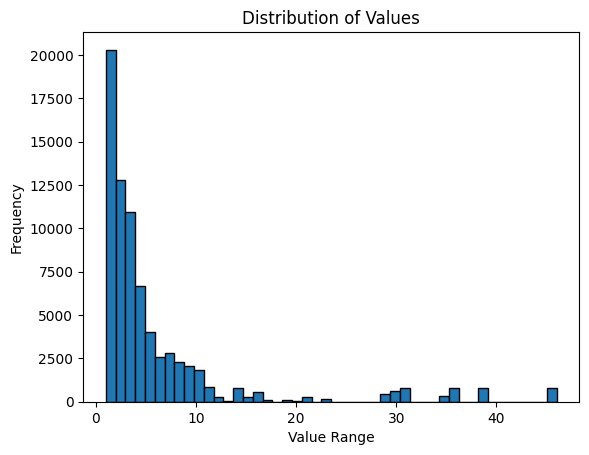

In [15]:
plt.hist(data['frequency'],bins=46,edgecolor='black')
plt.title('Distribution of Values')
plt.xlabel('Value Range')
plt.ylabel('Frequency')
plt.show()

In [16]:
data['Totalprice']=data['Quantity']*data['UnitPrice']

In [17]:
data.groupby('CustomerID').agg({'InvoiceDate':np.max})

/tmp/ipython-input-3547284937.py:1: FutureWarning: The provided callable <function max at 0x7eafa0b277e0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  data.groupby('CustomerID').agg({'InvoiceDate':np.max})


,InvoiceDate
CustomerID,
12346.0,1/18/2011 10:17
12347.0,12-07-2010 14:57
12348.0,12/16/2010 19:09
12350.0,02-02-2011 16:01
12352.0,2/16/2011 12:33
...,...
18260.0,12/16/2010 18:23
18269.0,12/16/2010 15:39
18277.0,1/25/2011 12:34


## Customer DF

In [18]:
customer_df=data.groupby('CustomerID').agg({
    'InvoiceDate':'max',
    'InvoiceNo':'nunique',
    'Totalprice':'sum'
}).reset_index()

In [58]:
customer_df.head()

,CustomerID,InvoiceDate,InvoiceNo,Recency,Frequency_Score,Monetary,Recency_Days
0,12346.0,2011-01-18 10:17:00,2,1,3,0.00,48
1,12347.0,2010-12-07 14:57:00,2,1,3,1187.18,89
2,12348.0,2010-12-16 19:09:00,2,1,3,1120.24,80
3,12350.0,2011-02-02 16:01:00,1,2,1,334.40,32
4,12352.0,2011-02-16 12:33:00,5,3,5,440.85,19


In [19]:
print(len(customer_df['CustomerID']))
print(len(customer_df['InvoiceDate']))
print(len(customer_df['InvoiceNo']))
print(len(customer_df['Totalprice']))

1845
1845
1845
1845


In [38]:
customer_df.isnull().sum()

,0
CustomerID,0
InvoiceDate,0
InvoiceNo,0
Recency,0
Frequency_Score,0
Monetary,0


In [21]:
customer_df.dropna(inplace=True)

In [22]:
print(len(customer_df['CustomerID']))
print(len(customer_df['InvoiceDate']))
print(len(customer_df['InvoiceNo']))
print(len(customer_df['Totalprice']))

1845
1845
1845
1845


### recency part

In [23]:
customer_df['InvoiceDate']=pd.to_datetime(customer_df['InvoiceDate'],format='mixed')

In [24]:
def decide_recency(recent_date,customer_last_purchase):
  date=abs((recent_date-customer_last_purchase)).days
  #print(date)
  if date < 5:
    return 5
  elif date < 14:
    return 4
  elif date < 21:
    return 3
  elif date < 35:
    return 2
  else:
    return 1

In [53]:
def recency_dayt(customer_last_purchase):
  date=abs((recent_date-customer_last_purchase)).days
  return date

In [54]:
def recency_score(customer_last_purchase):
  score=decide_recency(recent_date,customer_last_purchase)
  return score

In [55]:
#date format in dataset:- m/d/y h:m

recent_date=customer_df['InvoiceDate'].max()
recent_datee=customer_df['InvoiceDate'].min()
print(recent_date)
print(recent_datee)

2011-03-07 13:10:00
2010-12-01 08:35:00


In [56]:
customer_df['Recency']=customer_df['InvoiceDate'].map(recency_score)

In [57]:
customer_df['Recency_Days']=customer_df['InvoiceDate'].apply(recency_dayt)

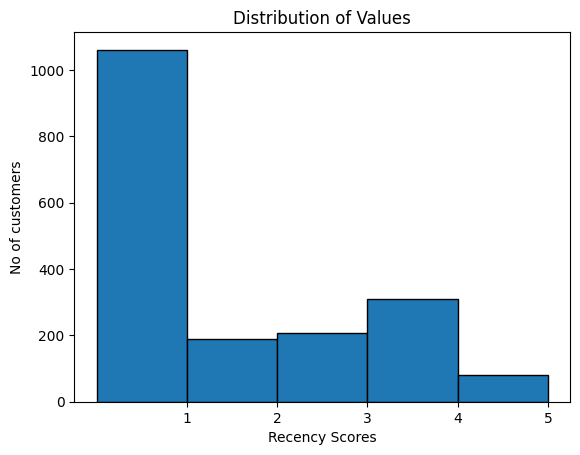

In [28]:
customer_df['Recency'].plot(kind='hist',bins=[0.5,1.5,2.5,3.5,4.5,5.5],edgecolor='black',align='left')
plt.title('Distribution of Values')
plt.xlabel("Recency Scores")
plt.ylabel("No of customers")
plt.xticks([1,2,3,4,5])
plt.show()

### frequency

In [29]:

percentiles = customer_df['InvoiceNo'].quantile([0.2, 0.4, 0.6, 0.8])
p20 = percentiles[0.2]
p40 = percentiles[0.4]
p60 = percentiles[0.6]
p80 = percentiles[0.8]
def assign_frequency_score(freq):
    if freq <= p20:
        return 1
    elif freq <= p40:
        return 2
    elif freq <= p60:
        return 3
    elif freq <= p80:
        return 4
    else:
        return 5
customer_df['Frequency_Score'] = customer_df['InvoiceNo'].apply(assign_frequency_score)


[]

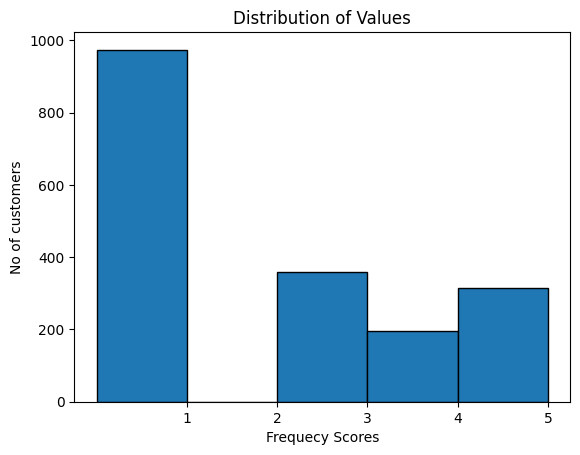

In [30]:
plt.hist(customer_df['Frequency_Score'],bins=[0.5,1.5,2.5,3.5,4.5,5.5],edgecolor='black',align='left')
plt.title('Distribution of Values')
plt.xlabel("Frequecy Scores")
plt.ylabel("No of customers")
plt.xticks([1,2,3,4,5])
plt.plot()

### monetary

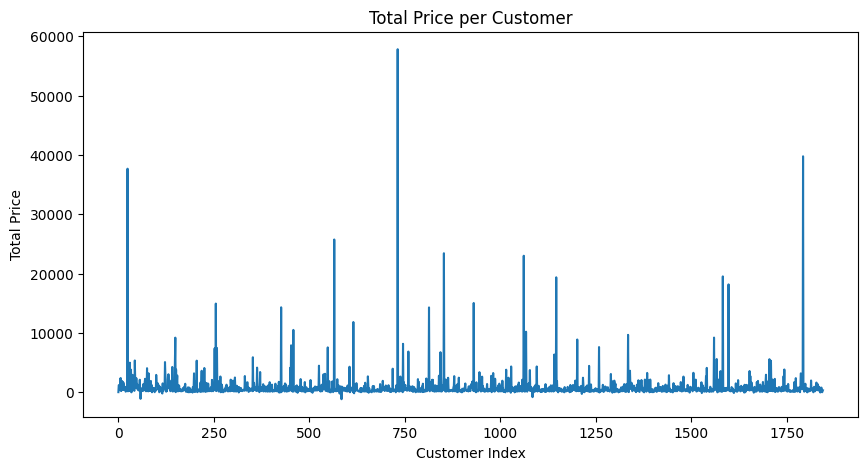

In [31]:
plt.figure(figsize=(10,5))
plt.plot(customer_df['Totalprice'].values)
plt.title("Total Price per Customer")
plt.xlabel("Customer Index")
plt.ylabel("Total Price")
plt.show()


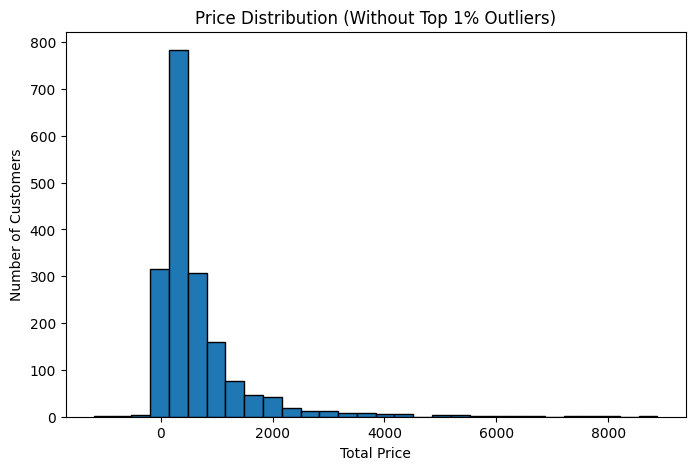

In [32]:
import numpy as np

q99 = np.percentile(customer_df['Totalprice'], 99)
filtered = customer_df[customer_df['Totalprice'] <= q99]

plt.figure(figsize=(8,5))
plt.hist(filtered['Totalprice'], bins=30, edgecolor='black')
plt.title("Price Distribution (Without Top 1% Outliers)")
plt.xlabel("Total Price")
plt.ylabel("Number of Customers")
plt.show()


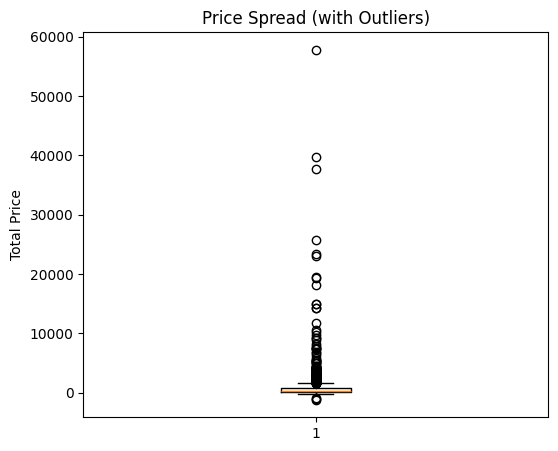

In [33]:
plt.figure(figsize=(6,5))
plt.boxplot(customer_df['Totalprice'], vert=True)
plt.title("Price Spread (with Outliers)")
plt.ylabel("Total Price")
plt.show()

In [34]:
customer_df['Monetary']=customer_df['Totalprice']

In [35]:
customer_df.drop('Totalprice',axis=1,inplace=True)

In [36]:
customer_df.columns

Index(['CustomerID', 'InvoiceDate', 'InvoiceNo', 'Recency', 'Frequency_Score',
       'Monetary'],
      dtype='object')

## MODEL TRAINING

In [78]:
customer_df.head()

,CustomerID,InvoiceDate,InvoiceNo,Recency,Frequency_Score,Monetary,Recency_Days,Cluster,Segment
0,12346.0,2011-01-18 10:17:00,2,1,3,0.00,48,0,Recent One-Time Buyers
1,12347.0,2010-12-07 14:57:00,2,1,3,1187.18,89,1,Hibernating
2,12348.0,2010-12-16 19:09:00,2,1,3,1120.24,80,1,Hibernating
3,12350.0,2011-02-02 16:01:00,1,2,1,334.40,32,0,Recent One-Time Buyers
4,12352.0,2011-02-16 12:33:00,5,3,5,440.85,19,0,Recent One-Time Buyers


In [62]:
from sklearn.preprocessing import StandardScaler

features=customer_df[['Recency_Days', 'InvoiceNo', 'Monetary']]

scaler=StandardScaler()
scaled_features=scaler.fit_transform(features)

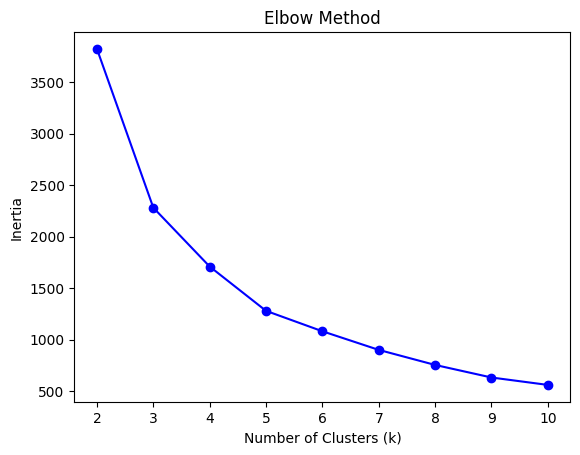

In [66]:
# elbow method to decide how many clusters we need to make

inertias=[]
k_range=range(2,11)

for k in k_range:

  k_means=KMeans(n_clusters=k,random_state=42,n_init=10)
  k_means.fit(scaled_features)
  inertias.append(k_means.inertia_)

plt.plot(k_range,inertias,'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [67]:
optimal_k=5
kmeans=KMeans(n_clusters=optimal_k,random_state=42,n_init=10)
customer_df['Cluster']=kmeans.fit_predict(scaled_features)

In [72]:
cluster_anaylsis=customer_df.groupby('Cluster').agg({
    'Recency_Days': 'mean',
    'InvoiceNo': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)

print(cluster_anaylsis)

         Recency_Days  InvoiceNo  Monetary  CustomerID
Cluster                                               
0               22.11       1.80    552.02         928
1               82.53       1.97    523.23         810
2               22.00      35.14   9148.32           7
3               42.33      10.00  29385.08           9
4               26.69       9.41   3438.05          91


In [73]:
from sklearn.metrics import silhouette_score

score = silhouette_score(scaled_features, customer_df['Cluster'])
print(f'Silhouette Score: {score}')

Silhouette Score: 0.5683387320152671


In [76]:
cluster_profiles = customer_df.groupby('Cluster').agg({
    'Recency_Days': 'mean',
    'InvoiceNo': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)

cluster_profiles.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Customer_Count']
print(cluster_profiles)

         Avg_Recency  Avg_Frequency  Avg_Monetary  Customer_Count
Cluster                                                          
0              22.11           1.80        552.02             928
1              82.53           1.97        523.23             810
2              22.00          35.14       9148.32               7
3              42.33          10.00      29385.08               9
4              26.69           9.41       3438.05              91


In [77]:
cluster_names = {
    0: 'Recent One-Time Buyers',
    1: 'Hibernating',
    2: 'Champions',
    3: 'High-Value Loyalists',
    4: 'Loyal Customers'
}

customer_df['Segment'] = customer_df['Cluster'].map(cluster_names)
